In [1]:
import functions
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchinfo import summary
from tqdm import tqdm

In [2]:
DATASET_PATH = "/scratch/kirschstein/LamaH-CE"

In [3]:
results_df = pd.read_csv("results_topology_2023-09-27 10:38:10.568799.csv", index_col=0)
mse_df = results_df.loc[[f"GCNII_bidirectional_learned_{fold}_MSE" for fold in range(6)]]
nse_df = results_df.loc[[f"GCNII_bidirectional_learned_{fold}_NSE" for fold in range(6)]]

In [4]:
mse_df.mean(1)

GCNII_bidirectional_learned_0_MSE    222.771899
GCNII_bidirectional_learned_1_MSE    295.631497
GCNII_bidirectional_learned_2_MSE    389.683498
GCNII_bidirectional_learned_3_MSE    308.777419
GCNII_bidirectional_learned_4_MSE    451.713186
GCNII_bidirectional_learned_5_MSE    272.644077
dtype: float64

In [5]:
nse_df.mean(1)

GCNII_bidirectional_learned_0_NSE    0.923474
GCNII_bidirectional_learned_1_NSE    0.872703
GCNII_bidirectional_learned_2_NSE    0.822265
GCNII_bidirectional_learned_3_NSE    0.870988
GCNII_bidirectional_learned_4_NSE    0.798932
GCNII_bidirectional_learned_5_NSE    0.900733
dtype: float64

In [6]:
results_df.loc[[f"GCNII_bidirectional_learned_{fold}_MSE" for fold in range(6)]].mean(1).mean()

323.53692941278456

In [7]:
results_df.loc[[f"GCNII_bidirectional_learned_{fold}_MSE" for fold in range(6)]].mean(1).std()

83.12009548475173

In [6]:
best_run = nse_df.mean(1).idxmax()
print(best_run)

GCNII_bidirectional_learned_0_NSE


In [9]:
path = f"runs/topology/{best_run[:-4]}.run"
chkpt = torch.load(path)
print(json.dumps(chkpt["hparams"], indent=4))

{
    "data": {
        "window_size": 24,
        "stride_length": 1,
        "lead_time": 6,
        "normalized": true
    },
    "model": {
        "architecture": "GCNII",
        "num_layers": 20,
        "hidden_channels": 128,
        "param_sharing": false,
        "edge_orientation": "bidirectional",
        "adjacency_type": "learned"
    },
    "training": {
        "num_epochs": 20,
        "batch_size": 64,
        "learning_rate": 0.0005,
        "weight_decay": 0,
        "random_seed": 42,
        "train_years": [
            2015,
            2016,
            2006,
            2008,
            2014,
            2010,
            2013,
            2012,
            2002,
            2000,
            2005,
            2009,
            2001,
            2007,
            2003
        ],
        "holdout_size": 0.1388888888888889
    }
}


/home/kirschstein/miniconda3/envs/floodgnn/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
model, dataset = functions.load_model_and_dataset(chkpt, DATASET_PATH)
summary(model, depth=2)

Loading dataset into memory...


100%|█████████████████████████████████████████████████████████████████████████████████| 375/375 [03:26<00:00,  1.81it/s]


Layer (type:depth-idx)                   Param #
GCNII                                    374
├─Linear: 1-1                            15,488
├─Linear: 1-2                            129
├─ModuleList: 1-3                        --
│    └─GCN2Conv: 2-1                     16,384
│    └─GCN2Conv: 2-2                     16,384
│    └─GCN2Conv: 2-3                     16,384
│    └─GCN2Conv: 2-4                     16,384
│    └─GCN2Conv: 2-5                     16,384
│    └─GCN2Conv: 2-6                     16,384
│    └─GCN2Conv: 2-7                     16,384
│    └─GCN2Conv: 2-8                     16,384
│    └─GCN2Conv: 2-9                     16,384
│    └─GCN2Conv: 2-10                    16,384
│    └─GCN2Conv: 2-11                    16,384
│    └─GCN2Conv: 2-12                    16,384
│    └─GCN2Conv: 2-13                    16,384
│    └─GCN2Conv: 2-14                    16,384
│    └─GCN2Conv: 2-15                    16,384
│    └─GCN2Conv: 2-16                    16,384
│

In [11]:
worst_gauge = int(results_df.loc[best_run].idxmin())
print("worst gauge:", dataset.gauges[worst_gauge])

worst gauge: 80


In [12]:
window_size = chkpt["hparams"]["data"]["window_size"]
lead_time = chkpt["hparams"]["data"]["lead_time"]
time = range(-window_size + 1, window_size + 1)
functions.ensure_reproducibility(42)

In [15]:
predictions, deviations = functions.calculate_predictions_and_deviations_on_gauge(model, dataset, worst_gauge)

Testing: 100%|████████████████████████████████████████████████████████████████████| 26217/26217 [07:28<00:00, 58.42it/s]


In [24]:
deviations_df = pd.DataFrame({0: predictions, 1: deviations})
deviations_df.sort_values(1, ascending=False, inplace=True)
idx_list = list(deviations_df.index)
i = 0
while i < len(idx_list):
    to_drop = [j for j in range(i + 1, len(idx_list)) if abs(idx_list[j] - idx_list[i]) < window_size]
    if i == 0:
        assert 1 in to_drop
    idx_list = [idx for j, idx in enumerate(idx_list) if j not in to_drop]
    if i == 0:
        assert 5194 not in idx_list
    i += 1
worst_timesteps = deviations_df.loc[idx_list]
print(worst_timesteps)

              0          1
5193   1.563699  27.632589
21992  0.511909  22.700010
13855  0.236086  22.403418
14957  1.716480  21.599516
5304   3.959384  18.211775
...         ...        ...
117   -0.485440   0.007065
20015 -0.092000   0.006511
17221 -0.407022   0.005265
9992  -0.394719   0.002727
958   -0.467747   0.001262

[845 rows x 2 columns]


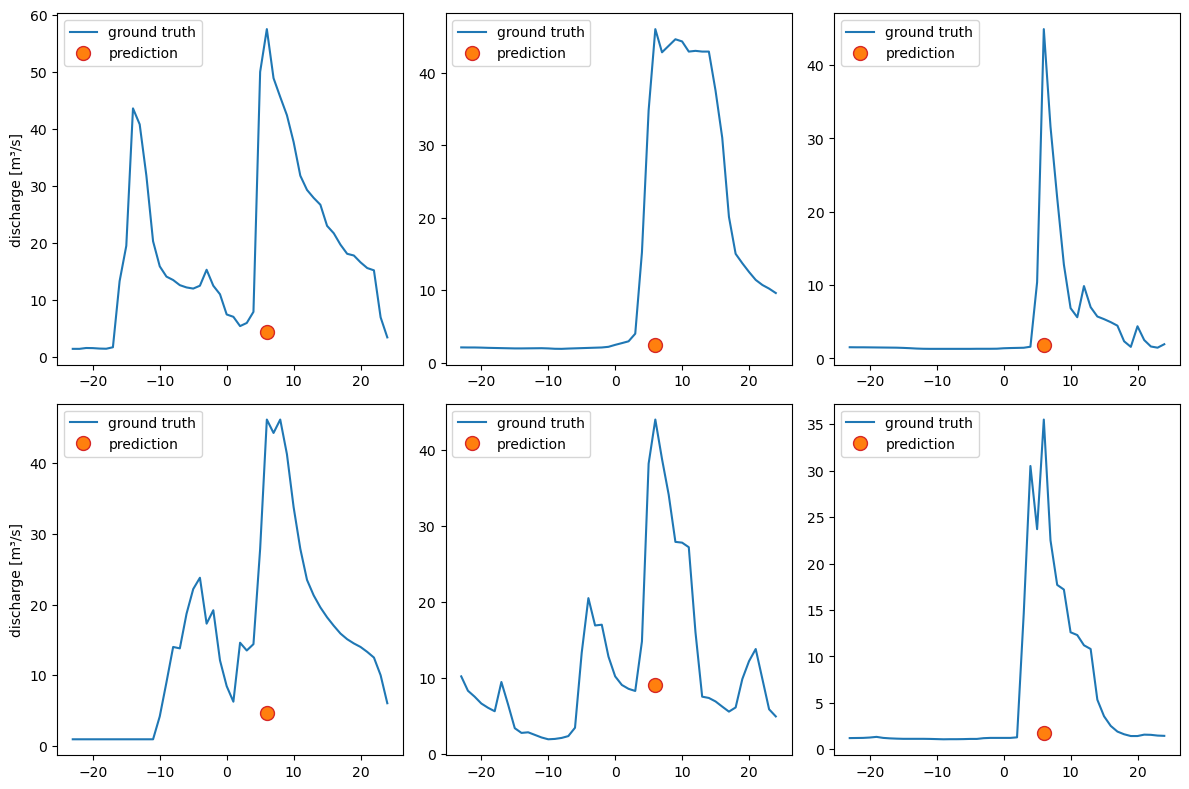

In [44]:
plt.figure(figsize=(12, 8))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for k, index in enumerate(worst_timesteps.index[:6]):
    truth = dataset.denormalize(torch.cat([dataset[index].x, dataset[index + window_size].x], dim=1))[worst_gauge, :, 0]
    pad = torch.zeros(dataset[index].x.size(0), 1, dataset[index].x.size(2))
    pad[worst_gauge, 0] = worst_timesteps.loc[index, 0]
    pred = dataset.denormalize(pad)[worst_gauge, 0, 0]
    plt.subplot(2, 3, k + 1)
    plt.plot(time, truth, label="ground truth", color=colors[0])
    plt.plot([lead_time], [pred], marker="o", color="w", markersize=10, markeredgecolor=colors[3], markerfacecolor=colors[1], label="prediction")
    if k // 3 == 5:
        plt.xlabel("time [s]")
    if k % 3 == 0:
        plt.ylabel("discharge [m³/s]")
    plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("worst_predictions.pdf")
plt.show()